Deriving Luminosity from an SED
===============================

This notebook demonstrates how to use the [dust_emissivity](https://github.com/keflavich/dustmass) module to compute the luminosity of a dusty source.

In [148]:
from __future__ import print_function
%matplotlib inline
from dust_emissivity.blackbody import modified_blackbody,integrate_sed,blackbody
from astropy import units as u
from astropy import constants
import pylab as pl

In [149]:
frequencies = np.logspace(2, 4, 1000)*u.GHz
fmin,fmax = frequencies.min(), frequencies.max()
print("Range: ",fmax.to(u.um, u.spectral()), " to ", fmin.to(u.um, u.spectral()))

Range:  29.9792458 um  to  2997.92458 um


In [150]:
temperature = 25*u.K

In [151]:
# modified blackbody returns normal bb units
modified_blackbody(fmin, temperature, beta=0).to(u.erg/u.s/u.cm**2/u.Hz)
# this is the flux per steradian, but angular units are not included in the dust_emissivity tools

<Quantity 1.3039727088156444e-16 erg / (cm2 Hz s)>

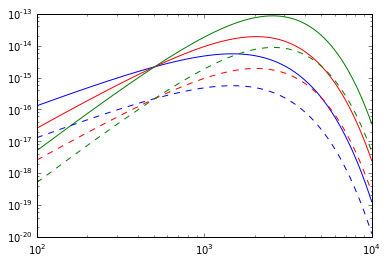

In [152]:
pl.loglog(frequencies, modified_blackbody(frequencies, temperature, beta=0, column=1e22*u.cm**-2), color='b')
pl.loglog(frequencies, modified_blackbody(frequencies, temperature, beta=1, column=1e22*u.cm**-2), color='r')
pl.loglog(frequencies, modified_blackbody(frequencies, temperature, beta=2, column=1e22*u.cm**-2), color='g')
pl.loglog(frequencies, modified_blackbody(frequencies, temperature, beta=0, column=1e21*u.cm**-2), color='b', linestyle='--')
pl.loglog(frequencies, modified_blackbody(frequencies, temperature, beta=1, column=1e21*u.cm**-2), color='r', linestyle='--')
pl.loglog(frequencies, modified_blackbody(frequencies, temperature, beta=2, column=1e21*u.cm**-2), color='g', linestyle='--')

In [153]:
integrated_sed = integrate_sed(fmin, fmax, function=modified_blackbody, temperature=25*u.K, beta=1.75)
print(integrated_sed) # not integrated over solid angle!

0.168799551811 erg / (cm2 s)


To compute the luminosity, we need to measure the emitting area.  For resolved, dusty objects, this is simply the angular area on the sky times the distance.  For example, a 25"x30" arcsecond Gaussian blob at a distance of 3.4 kpc:

In [154]:
# Area of a gaussian is 2*pi*a*b
angular_area = 2*np.pi*(25*u.arcsec*30*u.arcsec)
distance = 3.4*u.kpc
# Convert the angles to radians and treat them as unitless
physical_area = (angular_area*distance**2).to(u.cm**2, u.dimensionless_angles())
#physical_area = (angular_area_in_arcseconds / arcsec_per_radian**2) * distance_in_cm**2
print("Source area: ",physical_area," and effective physical radius: ", (physical_area**0.5).to(u.pc))

Source area:  1.21912935864e+37 cm2  and effective physical radius:  1.13155156532 pc


In [155]:
# integrated SED * area * pi steradians, since the integrated_sed is per steradian
luminosity = integrated_sed * physical_area * np.pi
print(luminosity.to(u.L_sun))

1680.97661544 solLum


Now let's go back the other way and determine how bright the source would be.  We are aiming to determine its brightness in MJy/sr.

In [156]:
flux_density = modified_blackbody((500*u.um).to(u.GHz,u.spectral()), temperature=25*u.K, beta=1.75, column=1e22*u.cm**-2)
print(flux_density,flux_density.to(u.Jy))

3.71537524828e-15 erg / (cm2 Hz s) 371537524.828 Jy


In [157]:
# Total energy emitted at the source location in a spectral bin per second
e_per_bin = flux_density*physical_area
print(e_per_bin)

4.52952304354e+22 erg / (Hz s)


In [158]:
# Dilute that by the distance**2
received_e_per_bin = (e_per_bin / distance**2).to(u.erg/u.s/u.Hz/u.cm**2)
print(received_e_per_bin)

4.11522465561e-22 erg / (cm2 Hz s)


In [159]:
# Then divide out the amount of sky that energy occupies
surface_brightness = received_e_per_bin/angular_area
print(surface_brightness)

8.73277794499e-26 erg / (arcsec2 cm2 Hz s)


In [160]:
# Convert that to the desired unit
print(surface_brightness.to(u.MJy/u.sr))

371.537524828 MJy / sr


In [161]:
# Put that all together:
surface_brightness = (flux_density * physical_area / distance**2 / angular_area).to(u.MJy/u.sr)
surface_brightness = ((flux_density / distance**2 * physical_area) / angular_area).to(u.MJy/u.sr)
print(surface_brightness)

371.537524828 MJy / sr


In [162]:
(flux_density/u.sr).to(u.MJy/u.sr)

<Quantity 371.5375248282618 MJy / sr>

Vega
====

Tests with Vega to see that we're sane.  Vega, with $M_V=0$, should have $S_\nu \sim 4000$ Jy at 500 nm.

In [163]:
# Spectral intensity without regard for distance
b_vega = blackbody((0.5*u.um).to(u.Hz,u.spectral()), 10000*u.K)
b_vega.to(u.Jy)

<Quantity 1.895152481731683e+19 Jy>

In [164]:
r_vega = 2.818*constants.R_sun
d_vega = (25.05*u.lyr).to(u.pc)
angular_area_vega = (r_vega/d_vega)**2 * np.pi * u.sr

Put Vega at a reasonable distance with two different methods for more sanity checks.

In [165]:
(b_vega * (r_vega**2 * np.pi) / d_vega**2).to(u.Jy)

<Quantity 4072.0721833855328 Jy>

In [166]:
(b_vega * angular_area_vega).to(u.Jy, u.dimensionless_angles())

<Quantity 4072.0721833855328 Jy>

The surface brightness of Vega:

In [167]:
((b_vega * angular_area_vega).to(u.Jy, u.dimensionless_angles()) / angular_area_vega).to(u.MJy/u.sr)

<Quantity 18951524817316.832 MJy / sr>

An example specific to The Snake
================================

In [168]:
T = 24*u.K
angular_area = (8*u.arcsec)**2
distance = 3.6*u.kpc
physical_area = (angular_area.to(u.rad**2)*distance**2).to(u.cm**2, u.dimensionless_angles())
beta = 1.75

In [169]:
nu = (np.array([70,160,250,350,500])*u.um).to(u.Hz,u.spectral())
column = 1e23*u.cm**-2

In [170]:
flux_density = modified_blackbody(nu, T, column=column, beta=beta)

In [171]:
surface_brightness = ((flux_density / distance**2 * physical_area) / angular_area).to(u.MJy/u.sr)
surface_brightness2 = ((flux_density / (u.sr))).to(u.MJy/u.sr)
surface_brightness,surface_brightness2

(<Quantity [ 12069.25897604, 39742.21507926, 20739.83151157,
              9405.08410352,  3427.14928482] MJy / sr>,
 <Quantity [ 12069.25897604, 39742.21507926, 20739.83151157,
              9405.08410352,  3427.14928482] MJy / sr>)

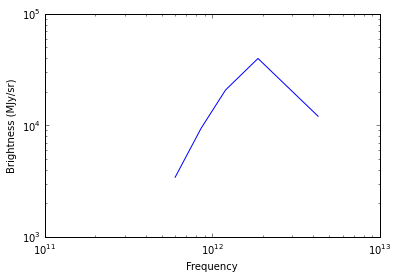

In [172]:
pl.loglog(nu, surface_brightness)
pl.xlabel("Frequency")
pl.ylabel("Brightness (MJy/sr)")

Another Stellar Example
-----------------------
Goal: determine K-band flux of a given star as a function of distance

Vacca, Garmany, Shull 1996: an O6.5V star has $T_{eff} = 42280$ K, $R = 10.3$ R$_\odot$, and $L=10^{5.486}$ L$_\odot$

In [173]:
K_O6 = blackbody((2.2*u.um).to(u.Hz,u.spectral()), 42280*u.K).to(u.Jy)
K_O6

<Quantity 2.230393541301617e+19 Jy>

In [174]:
r_O6 = 10.3*constants.R_sun
dist = 1*u.kpc
angular_area = (r_O6/dist)**2 * np.pi * u.sr

In [175]:
flux_K_O6 = (K_O6 * angular_area).to(u.Jy, u.dimensionless_angles())
flux_K_O6

<Quantity 3.776669578859788 Jy>

In [176]:
flux_K_mag0 = 666.6*u.Jy # from 2MASS via file:///Users/adam/repos/adamginsburg.github.com/filtersets.htm
mag_O6_K = -2.512*(np.log10(flux_K_O6.value) - np.log10(flux_K_mag0.value))
mag_O6_K

5.6438518740710588

In [177]:
# now the same at a distance of 5.4 kpc (for W51)
mag_O6_K_W51 = mag_O6_K + 2.512*2*np.log10(5.41/1.0)
mag_O6_K_W51

9.3274349339664635

Now, the same for an O9.5.  $L=10^{4.972}$, $R=8.5$, $T_{eff}=34620$

In [178]:
K_O9 = blackbody((2.2*u.um).to(u.Hz,u.spectral()), 34620*u.K).to(u.Jy)
K_O9

<Quantity 1.7944408169640477e+19 Jy>

In [179]:
R_O9 = 8.5*constants.R_sun

In [180]:
flux_K_O9 = (K_O9 * (R_O9/dist)**2 * np.pi * u.sr).to(u.Jy, u.dimensionless_angles())
mag_O9_K = -2.512*(np.log10(flux_K_O9.value) - np.log10(flux_K_mag0.value))
mag_O9_K

6.3002097352814674

In [181]:
mag_O9_K_W51 = mag_O9_K + 2.512*2*np.log10(5.41/1.0)
mag_O9_K_W51

9.983792795176873

In [182]:
# luminosity check:
integrated_sed_O9 = integrate_sed(50*u.AA, 50*u.um, function=blackbody, temperature=34620*u.K)
integrated_sed_O9

<Quantity 25928056699415.84 erg / (cm2 s)>

In [183]:
(constants.sigma_sb * (34620*u.K)**4).to(u.erg/u.s/u.cm**2)

<Quantity 81455400263707.94 erg / (cm2 s)>

In [184]:
(constants.sigma_sb * (34620*u.K)**4).to(u.erg/u.s/u.cm**2) / integrated_sed_O9

<Quantity 3.1415929549993282>

Check that the luminosity comes out right.

In [185]:
surface_area_O9 = 4*np.pi*R_O9**2
lum_O9 = (integrated_sed_O9 * np.pi * surface_area_O9).to(u.L_sun)
lum_O9
print("Computed luminosity {0} vs VGS96: {1}".format(lum_O9, 10**4.972*u.L_sun))

Computed luminosity 93017.0443516 solLum vs VGS96: 93756.2006926 solLum


In [188]:
# One last time, for B0.5
T_B0 = 32060*u.K
K_B0 = blackbody((2.2*u.um).to(u.Hz,u.spectral()), T_B0).to(u.Jy)
R_B0 = 8.0*constants.R_sun
flux_K_B0 = (K_B0 * (R_B0/dist)**2 * np.pi * u.sr).to(u.Jy, u.dimensionless_angles())
mag_B0_K = -2.512*(np.log10(flux_K_B0.value) - np.log10(flux_K_mag0.value))
mag_B0_K_W51 = mag_B0_K + 2.512*2*np.log10(5.41/1.0)
integrated_sed_B0 = integrate_sed(50*u.AA, 50*u.um, function=blackbody, temperature=T_B0)
(constants.sigma_sb * (T_B0)**4).to(u.erg/u.s/u.cm**2) / integrated_sed_B0
surface_area_B0 = 4*np.pi*R_B0**2
lum_B0 = (integrated_sed_B0 * np.pi * surface_area_B0).to(u.L_sun)
print("Computed luminosity {0} vs VGS96: {1}".format(lum_B0, 10**4.789*u.L_sun))
print("M_K = {0}".format(mag_B0_K_W51))

Computed luminosity 60596.9091381 solLum vs VGS96: 61517.687271 solLum
M_K = 10.2083758278
